In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import zipfile
import cv2
import itertools

import tensorflow
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
file_name = '/content/drive/Othercomputers/My Computer/Computer vision/projects/dl and cnns/classification chest x rays/chest x ray images.zip'
# file_name = './chest x ray images.zip'
dir='./'
zip_ref = zipfile.ZipFile(file_name, 'r')
zip_ref.extractall(dir)
zip_ref.close()

In [24]:
print('number of normal training images: ', len(os.listdir('./chest_xray/train/NORMAL')))
print('number of pneumonia training images: ', len(os.listdir('./chest_xray/train/PNEUMONIA')))
print('number of normal testing images: ', len(os.listdir('./chest_xray/test/NORMAL')))
print('number of pneumonia testing images: ', len(os.listdir('./chest_xray/test/PNEUMONIA')))

number of normal training images:  1341
number of pneumonia training images:  3875
number of normal testing images:  234
number of pneumonia testing images:  390


In [14]:
TRAINIG_DIR = './chest_xray/train/'
train_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest').flow_from_directory(
        TRAINIG_DIR,
        batch_size=16,
        class_mode='binary',
        target_size=(224, 224)
    )

VALIDATION_DIR = './chest_xray/val/'
validation_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(VALIDATION_DIR, batch_size=16, class_mode='binary', target_size=(224, 224))

TESTING_DIR = './chest_xray/test/'
validation_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(TESTING_DIR, batch_size=16, class_mode='binary', target_size=(224, 224))

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [25]:
inputs = layers.Input(shape=(224, 224, 3))
outputs = EfficientNetB0(include_top=False, weights='imagenet', classes=2)(inputs)
x = layers.GlobalAveragePooling2D(name='avg_pool')(outputs)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)
# x = layers.Dense(128, activation='relu', kernel_initializer='he_uniform')(x)
# x = layers.BatchNormalization()(x)
# x = layers.Dropout(0.2)(x)
output = layers.Dense(1, activation='sigmoid')(x)
model = Model(inputs, output)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')

In [9]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, TensorBoard
#Overwrite the model each time accuracy improves. Saves a lot of space. 
filepath="./best_model.hdf5" #File name includes epoch and validation accuracy.
#Use Mode = max for accuracy and min for loss. 
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

#https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
#This callback will stop the training when there is no improvement in
# the validation loss for three consecutive epochs.

#CSVLogger logs epoch, accuracy, loss, val_accuracy, val_loss. So we can plot later.
log_csv = CSVLogger('/content/drive/MyDrive/Colab Notebooks/saved_logs/my_logs.csv', separator=',', append=False)

callbacks_list = [checkpoint]
tb = TensorBoard(log_dir='.')

In [26]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=5,
    verbose=1,
    callbacks=callbacks_list
)

Epoch 1/5
326/326 [==============================] - ETA: 0s - loss: 0.2863 - accuracy: 0.9070
Epoch 1: val_accuracy did not improve from 0.62500
326/326 [==============================] - 162s 385ms/step - loss: 0.2863 - accuracy: 0.9070 - val_loss: 1.5976 - val_accuracy: 0.6250
Epoch 2/5
326/326 [==============================] - ETA: 0s - loss: 0.1565 - accuracy: 0.9438
Epoch 2: val_accuracy did not improve from 0.62500
326/326 [==============================] - 124s 381ms/step - loss: 0.1565 - accuracy: 0.9438 - val_loss: 4.6513 - val_accuracy: 0.6250
Epoch 3/5
326/326 [==============================] - ETA: 0s - loss: 0.1398 - accuracy: 0.9498
Epoch 3: val_accuracy did not improve from 0.62500
326/326 [==============================] - 124s 380ms/step - loss: 0.1398 - accuracy: 0.9498 - val_loss: 0.8406 - val_accuracy: 0.4119
Epoch 4/5
326/326 [==============================] - ETA: 0s - loss: 0.1114 - accuracy: 0.9574
Epoch 4: val_accuracy did not improve from 0.62500
326/326 [==

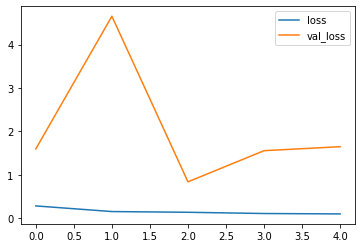

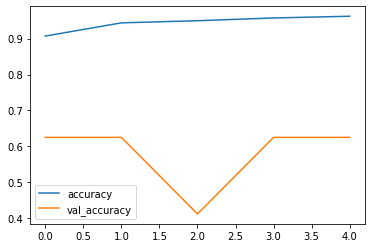

In [27]:
### with pandas
import pandas as pd
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot()

In [28]:
loss, accuracy = model.evaluate(validation_generator, batch_size=32)
print(loss, accuracy)

39/39 [==============================] - 6s 158ms/step - loss: 1.6494 - accuracy: 0.6250
1.649387240409851 0.625


Confusion matrix unnormalized
[[234   0]
 [390   0]]


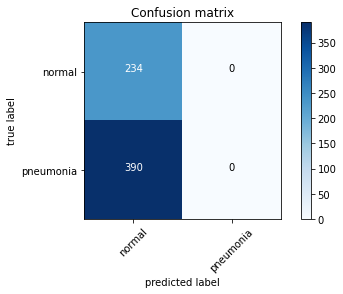

In [29]:
from sklearn.metrics import confusion_matrix

test_labels = validation_generator.classes
predictions = model.predict(x=validation_generator, steps=len(validation_generator), verbose=0)
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))
def plot_confusion_matrix(cm, 
                          classes, 
                          normalize=False, 
                          title='Confusion matrix', 
                          cmap=plt.cm.Blues):
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print('Normalized confusion matrix')
  else:
    print('Confusion matrix unnormalized')

  print(cm)
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0],), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment='center',
             color='white' if cm[i, j] > thresh else 'black')
    
  plt.tight_layout()
  plt.ylabel('true label')
  plt.xlabel('predicted label')


cm_plot_labels = ['normal', 'pneumonia']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion matrix')